# Proyecto Final ECD ITBA Sebastián Iglesias

El dataset de este trabajo fue obtenido de [C3 AI Data lake](https://c3.ai/customers/covid-19-data-lake/).

# Tabla de Contenidos
1. [Utilitarios](#Utilitarios)
    1. [Importando librerías](#Importando-librerías)
    2. [Funciones](#Funciones)
2. [Preprocesamiento de los datos](#Preprocesamiento-de-los-datos)
    1. [Obteniendo la primer radiografía](#Obteniendo-la-primer-radiografía) 
        1. [Buscar los detalles del diagnóstico](#Buscar-los-detalles-del-diagnóstico)
    2. [Almacenando el dataset](#Almacenando-el-dataset)
    3. [Muestras](#Muestras)
        1. [Ejemplo de radiografía frontal](#Ejemplo-de-radiografía-frontal)
        2. [Ejemplo de radiografía lateral](#Ejemplo-de-radiografía-lateral)
        3. [Ejemplo de radiografía cabeza](#Ejemplo-de-radiografía-cabeza)
    4. [Nuevo Tamaño](#Nuevo-Tamaño)
4. [Principal Component Analysis](#Principal-Component-Analysis)
    1. [PCA Train y test](#PCA-Train-y-test)
    2. [PCA Crear modelo](#PCA-Crear-modelo)
    3. [PCA Entrenar la red](#PCA-Entrenar-la-red)
    4. [PCA Probar la red](#PCA-Entrenar-la-red)
5. [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE))
    1. [tSNE Train y test](#tSNE-Train-y-test)
    2. [tSNE Crear modelo](#tSNE-Crear-modelo)
    3. [tSNE Entrenar la red pca](#tSNE-Entrenar-la-red-pca)
    4. [tSNE Probar la red pca](#tSNE-Entrenar-la-red-pca)


## Utilitarios
### Importando librerías

In [2]:
# Dependencias utilitarias
import requests
import urllib.request
import pandas as pd
import numpy as np
import os.path
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib import pyplot as plt
from scipy.stats import gamma
from PIL import Image, ImageOps
from io import BytesIO
from PIL.ExifTags import TAGS
from os import path
from os import listdir
from os.path import isfile, join
from tensorflow import keras
from tensorflow.keras import layers
from numpy import percentile


# Algoritmos para los modelos
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

# Directorios a usar para imágenes
imgDirectory = 'img/'
ctDir = 'ct_scan/'
frontalXRayDir = 'frontal_x-ray/'
sideXRayDir = 'sideways_x-ray/'
imgPath = f"{imgDirectory}{frontalXRayDir}gray/"
imgPath128 = f"{imgDirectory}{frontalXRayDir}128/gray/"

# Seed base
random_seed = 14061996

Esta notebook requiere tener una versión de pandas (>= 1.0.0).

In [3]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.0.1


### Funciones

Un conjunto de funciones a utilizar a lo largo del trabajo

In [4]:
# https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap

# Mostrar imágenes como una grilla
def display_images(
    images: [PilImage], 
    columns=10, width=100, height=100, max_images=10, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

# Verificar si una imagen existe en el directorio
def file_exists(fileId: str, directory: str):
    return os.path.exists(f"{directory}{fileId}")

# Devuelve 'CT', 'FRONT', 'SIDE', np.nan dependiendo si la imagen esta en un directorio especifico o si no existe
def getFileType(fileName: str):
    if file_exists(fileName, f"{imgDirectory}{ctDir}"):
        return 'CT'
    elif file_exists(fileName, f"{imgDirectory}{frontalXRayDir}"):
        return 'FRONT'
    elif file_exists(fileName, f"{imgDirectory}{sideXRayDir}"):
        return 'SIDE'
    return None

# Devuelve el ancho de un xray frontal en el directorio de xray
def getFileWidth(fileName: str):
    if (file_exists(fileName, f"{imgDirectory}{frontalXRayDir}")):
        width, height = Image.open(f"{imgDirectory}{frontalXRayDir}{fileName}").size
        return width
    else:
        return 0

# Devuelve la altura de un xray frontal en el directorio de xray
def getFileHeight(fileName: str):
    if (file_exists(fileName, f"{imgDirectory}{frontalXRayDir}")):
        width, height = Image.open(f"{imgDirectory}{frontalXRayDir}{fileName}").size
        return height
    else:
        return 0


## Preprocesamiento de los datos
### Obteniendo la primer radiografía

Se utilizarán métodos del archivo `c3aidatalake.py` que convierten una respuesta http JSON del API de C3.ai a un dataframe de la librería python Pandas.

In [5]:
import c3aidatalake

#### Buscar los detalles del diagnóstico

Siguiendo la documentación en: https://c3.ai/covid-19-api-documentation/#tag/Diagnosis, se hace uso del método provisto en c3aidatalake para obtener el dataset.

In [6]:
rawDiagnosis = c3aidatalake.fetch(
    "diagnosis",
    {
        "spec": {
            "filter": "contains(lowerCase(testResults), 'covid')"
        }
    }
)

rawDiagnosis

,imageUrl,source,idPatient,testResults,id,location.id,age,clinicalNotes,temperature
0,MONTREAL/images/00870a9c.jpg,Montreal,226,Pneumonia/Viral/COVID-19: positive,00870a9c.jpg,Hannover_Germany,NaN,NaN,NaN
1,MONTREAL/images/01E392EE-69F9-4E33-BFCE-E5C968...,Montreal,46,Pneumonia/Viral/COVID-19: positive,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Italy,55.0,"Woman, 55 years old, reports dyspnea for a few...",NaN
2,MONTREAL/images/03BF7561-A9BA-4C3C-B8A0-D3E585...,Montreal,77,Pneumonia/Viral/COVID-19: positive,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Italy,65.0,"Female patient, 65 years old, in a pathologica...",NaN
3,MONTREAL/images/071d06607edf81d70c940e043bce34...,Montreal,351,Pneumonia/Viral/COVID-19: positive,071d06607edf81d70c940e043bce34_jumbo.jpeg,UnitedKingdom,65.0,Presentation: SOB and myalgia.. Imaging Notes:...,NaN
4,MONTREAL/images/078d2e0b3e4fec1d603efb0e818c31...,Montreal,459,Pneumonia/Viral/COVID-19: positive,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Hungary,70.0,"DM, hypertension, congestive heart failure, ch...",NaN
...,...,...,...,...,...,...,...,...,...
1995,MONTREAL/images/radiol.2020200490.fig3.jpeg,Montreal,18,Pneumonia/Viral/COVID-19: positive,radiol.2020200490.fig3.jpeg,Jiangsu_China,53.0,Chest radiography of confirmed Coronavirus Dis...,NaN
1996,MONTREAL/images/radiol.2020201160.fig2a.jpeg,Montreal,151,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2a.jpeg,HongKong_China,NaN,NaN,NaN
1997,MONTREAL/images/radiol.2020201160.fig2b.jpeg,Montreal,152,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2b.jpeg,HongKong_China,NaN,NaN,NaN
1998,MONTREAL/images/radiol.2020201160.fig2c.jpeg,Montreal,153,Pneumonia/Viral/COVID-19: positive,radiol.2020201160.fig2c.jpeg,HongKong_China,NaN,NaN,NaN


Del conjunto de datos, se está interesado unicamente en el id (el nombre del archivo de la radiografía), el idPatient que representa a un id único por paciente y el testResult (Pneumonia/Viral/COVID-19).

In [7]:
diagnosis = rawDiagnosis[['idPatient', 'id', 'testResults']]

print(f"Cantidad de diagnósticos: {len(diagnosis)}")

examples = diagnosis.head(10)

examples

Cantidad de diagnósticos: 2000


,idPatient,id,testResults
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
5,249,08d780ae.jpg,Pneumonia/Viral/COVID-19: positive
6,350a,08ed451c576ee00935ee178ec85c57_jumbo-1.jpeg,Pneumonia/Viral/COVID-19: positive
7,352,0a6c60063b4bae4de001caaba306d1_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive
8,263,0a7faa2a.jpg,Pneumonia/Viral/COVID-19: positive
9,320,1-s2.0-S0085253820303616-gr1_lrg-a.png,Pneumonia/Viral/COVID-19: positive


El conjunto de datos de diagnósticos tiene una columna `id` que representa el id de la imagen. El API de C3.ai permite indagar más utilizando este `id`.

In [8]:
image_id = examples.loc[0, "id"] 
print(f"Identificador de Imagen: {image_id} \n")


image_urls = c3aidatalake.read_data_json(
    "diagnosis",
    "getimageurls",
    {
        "ids" : [image_id]
    }
)

url = image_urls["value"][image_id]["value"]

print(f"URL verdadera donde está ubicada la imagen: \n {url} \n ")

Identificador de Imagen: 00870a9c.jpg 

URL verdadera donde está ubicada la imagen: 
 https://dti--prod-covid.s3.amazonaws.com/fs/covid/prod/MONTREAL/images/00870a9c.jpg?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEGUaCXVzLWVhc3QtMSJHMEUCIFL%2BXtDPG0U%2FxizAjaxXMNmBY2hRGAvttS%2FTAFSrVQtzAiEAiYKogPCpk%2FjKsKPI%2BS5G%2B5WqUr6k8H%2BWj1Hj%2BGpMJVAqvQMI3v%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARADGgwyMDk5MjE2Mjk1ODUiDM4JVAdFV%2FZVYtjnPiqRAwHfltggBBJtxq96cBpfUhD%2BVlBskOR9vXwgO%2FpzcUuckv1zaeU7zILPkkjkQU74SaLcckOuMm9HcqzaSIuA9V03WuIG2OY3thUHVtwuOYlkmfewpbLH1mINeP06r5SEWp%2Bx1ZzhlldNqPvPlyhWJPYD9Wl17RI1YgkMMYRLJks080RQe2OlVhxBqIPUIjs1YdtqZhpPCa8TZdff6VbDBDiHHlxosDYEW0qc57XKiwIMkw91CpF1H7961pkhcpKj0%2FtuTycCC7vjmzgyfd%2FhMjdRY%2F%2Bz5NTs8A%2B95UkaOgxVadJkABJWBtkcP5bYmRCrjjAoBiOT0YHAC8gQ7Wati2DMrZehCy345CfiEqzYPkoahBWpQsYzaitWe%2BoCg%2FtKa7Ft8VVAfiAKapBD1ON9O7s6I9hc3qndUy3mOUe92Dv%2BGZFqUhcsLLOZCC%2BxVFWUknGg7BbjJv2QkrYNNSQ0ocoWuPj1GCaZaKJHP1294vPAwspSv6HmjAAhRSPWCwGlpz27P6%2FJnpyFX6l%2FfYr7gLYxMLHHwYQGOusBmF0

Revisando la verdadera URL de la imagen:

Información del archivo de la imagen: 
Ancho: 2000px Alto: 2000px
La imagen mostrada a continuación fue achicada para que no ocupe mucho espacio en el notebook. No representa su tamaño verdadero.


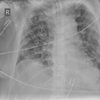

In [9]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))

print("Información del archivo de la imagen: ")
width, height = img.size
print(f"Ancho: {width}px Alto: {height}px")
print("La imagen mostrada a continuación fue achicada para que no ocupe mucho espacio en el notebook. No representa su tamaño verdadero.")
img.resize((100,100))


Es necesario almacenar localmente las imágenes para evitar reiterados llamados a la API de C3.ai y poder pre-procesar las imágenes y aplicar los algoritmos de reducción de dimensionalidad. Esto requerirá trabajar sobre el objeto `diagnosis`, normalizando parámetros y ordenándolo.

In [10]:
idList = diagnosis['id'].to_numpy().tolist()
print(f"Length of id list: {len(idList)}")

Length of id list: 2000


### Almacenando el dataset
Se descarga y almacena el conjunto de imágenes localmente, para evitar reiterados llamadas a la API. Si una imágen ya se descargaro una vez, no se vuelve a llamar a la API.

In [11]:
print('Comenzando descarga...')

# Aunque las especificaciones del API c3ai diga que se permite pasar un arreglo de ids
# el API limita la respuesta y envía el resultado de un sólo id
# Se optó ir por un método iterativo dada esa restricción.

for id in idList:
    file = f"{imgDirectory}{id}"
    # Si el file existe en el directorio, o si el id no tiene una extensión válida, no descarga
    if (not path.exists(file)) and  ('.' in id):
        print(f"\t Downloading: {id}")
        try:
            # Primer llamado para obtener la URL real de la imagen
            obj = c3aidatalake.read_data_json(
                "diagnosis",
                "getimageurls",
                {
                    "ids" : [id]
                }
            )
            # Segundo llamado para descargar la imagen de la URL real
            urllib.request.urlretrieve(obj['value'][id]['value'], file)
        # En caso de tener una respuesta con código 4xx ó 5xx
        except urllib.error.HTTPError as exception:
            print(exception)

print('Descarga Finalizada.')

Comenzando descarga...
	 Downloading: coronacases_org_001.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_002.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_003.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_004.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_005.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_006.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_007.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_008.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_009.nii.gz
HTTP Error 404: Not Found
	 Downloading: coronacases_org_010.nii.gz
HTTP Error 404: Not Found
Descarga Finalizada.


Ahora con las imágenes descargadas, bajo el directorio `imgDirectory`, es necesario agregar nuevas columnas de datos de cada registro.

El conjunto de datos tiene tanto radiografías de cabeza, como tambien radiografías de pecho frontales y laterales. Se usará el grupo mayoritario de imágenes para el análisis. 

Se debe hacer una separación manual de cada uno de estos tipos.


### Muestras

#### Ejemplo de radiografía frontal

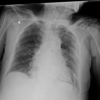

In [12]:
Image.open(f"{imgDirectory}{frontalXRayDir}0a6c60063b4bae4de001caaba306d1_jumbo.jpeg").resize((100,100))

#### Ejemplo de radiografía lateral

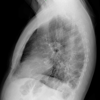

In [13]:
Image.open(f"{imgDirectory}{sideXRayDir}covid-19-pneumonia-20-l-on-admission.jpg").resize((100,100))

#### Ejemplo de radiografía cabeza

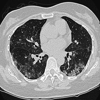

In [14]:
Image.open(f"{imgDirectory}{ctDir}1-s2.0-S0929664620300449-gr3_lrg-c.jpg").resize((100,100))

In [15]:
# List of downloaded images
ctList = [f for f in listdir(f"{imgDirectory}{ctDir}") if isfile(join(f"{imgDirectory}{ctDir}", f))]
frontalXRayList = [f for f in listdir(f"{imgDirectory}{frontalXRayDir}") if isfile(join(f"{imgDirectory}{frontalXRayDir}", f))]
sideXRayList = [f for f in listdir(f"{imgDirectory}{sideXRayDir}") if isfile(join(f"{imgDirectory}{sideXRayDir}", f))]

print("Cantidades de radiografías: \n")
print(f"Cabeza: {len(ctList)}")
print(f"Pecho frontal: {len(frontalXRayList)}")
print(f"Pecho lateral: {len(sideXRayList)}")

Cantidades de radiografías: 

Cabeza: 43
Pecho frontal: 475
Pecho lateral: 26


Se hace un dataframe que muestre esta información y permita filtrar únicamente las radiografías frontales de pecho.

In [16]:
df = pd.DataFrame(diagnosis)
df['imageType'] = df['id'].apply(lambda x: getFileType(x))
df

,idPatient,id,testResults,imageType
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT


Se verifica que los valores de la nueva columna `imageType` correspondan con las imágenes en los directorios.

In [17]:
ctA, ctB = df[df.imageType.eq('CT')].shape
fA, fB = df[df.imageType.eq('FRONT')].shape
sA, sB = df[df.imageType.eq('SIDE')].shape
nA, nB = df[df.imageType.isnull()].shape

print("Cantidades de radiografías: \n")
print(f"Cabeza: {ctA}")
print(f"Pecho frontal: {fA}")
print(f"Pecho lateral: {sA}")
print(f"NAN: {nA}")

Cantidades de radiografías: 

Cabeza: 43
Pecho frontal: 474
Pecho lateral: 26
NAN: 1457


De los 2000 registros originales, 1457 deben ser dejados de lado por ser imágenes no válidas(sea por tener una extensión inválida, archivos corruptos o imposibilidad de acceder a la imagen real y descargarse).

De las 543 imágenes restantes, 43 son radiografías de la cabeza, 26 de pecho lateral también son dejadas de lado. 474 radiografías frontales de pecho permanecen en el dataframe.

In [18]:
df = df[df['imageType'] == 'FRONT']
df

,idPatient,id,testResults,imageType
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT


In [19]:
ctA, ctB = df[df.imageType.eq('CT')].shape
fA, fB = df[df.imageType.eq('FRONT')].shape
sA, sB = df[df.imageType.eq('SIDE')].shape
nA, nB = df[df.imageType.isnull()].shape

print("Cantidades de radiografías en el dataframe luego de purgar los otros tipos: \n")
print(f"Cabeza: {ctA}")
print(f"Frontales: {fA}")
print(f"Laterales: {sA}")
print(f"NAN: {nA}")

Cantidades de radiografías en el dataframe luego de purgar los otros tipos: 

Cabeza: 0
Frontales: 474
Laterales: 0
NAN: 0


### Nuevo Tamaño

Aunque se quiera aprovechar la mayor cantidad posible, se debe estandarizar el tamaño de las imágenes. Se opta por utilizar la resolución mīnima de las imágenes para hacer esa estandarización. 

Se crean dos nuevas columnas en el dataframe, una con el ancho y otra con el alto de cada imágen medido en pixeles.

In [20]:
df['width'] = df['id'].apply(lambda x: getFileWidth(x))
df['height'] = df['id'].apply(lambda x: getFileHeight(x))
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,idPatient,id,testResults,imageType,width,height
0,226,00870a9c.jpg,Pneumonia/Viral/COVID-19: positive,FRONT,2000,2000
1,46,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1989,1482
2,77,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1610,1632
3,351,071d06607edf81d70c940e043bce34_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1024,817
4,459,078d2e0b3e4fec1d603efb0e818c31_jumbo.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1024,750
...,...,...,...,...,...,...
1995,18,radiol.2020200490.fig3.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,1300,1343
1996,151,radiol.2020201160.fig2a.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,906,798
1997,152,radiol.2020201160.fig2b.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,894,799
1998,153,radiol.2020201160.fig2c.jpeg,Pneumonia/Viral/COVID-19: positive,FRONT,842,835


In [21]:
print("5 number summary de las columnas de ancho y alto: \n")

width_quartiles = percentile(df['width'], [25, 50, 75])
width_min, width_max = df['width'].min(), df['width'].max()

height_quartiles = percentile(df['height'], [25, 50, 75])
height_min, height_max = df['height'].min(), df['height'].max()

print('Ancho: ')
print('\t Min: %.3f' % width_min)
print('\t Q1: %.3f' % width_quartiles[0])
print('\t Median: %.3f' % width_quartiles[1])
print('\t Q3: %.3f' % width_quartiles[2])
print('\t Max: %.3f' % width_max)

print('Alto: ')
print('\t Min: %.3f' % height_min)
print('\t Q1: %.3f' % height_quartiles[0])
print('\t Median: %.3f' % height_quartiles[1])
print('\t Q3: %.3f' % height_quartiles[2])
print('\t Max: %.3f' % height_max)

5 number summary de las columnas de ancho y alto: 

Ancho: 
	 Min: 220.000
	 Q1: 770.500
	 Median: 1044.500
	 Q3: 2000.000
	 Max: 5623.000
Alto: 
	 Min: 202.000
	 Q1: 692.000
	 Median: 1016.500
	 Q3: 2000.000
	 Max: 4757.000


In [ ]:
xRays = []
xRays128 = []
for index, path in enumerate(df['id']):
    originalImg = Image.open(f"{imgDirectory}{frontalXRayDir}{path}")
    grayScaledResizedImg = ImageOps.grayscale(originalImg).resize((220,202))
    grayScaledResizedImg128 = ImageOps.grayscale(originalImg).resize((128,128))
    grayScaledResizedImg.save(f"{imgDirectory}{frontalXRayDir}gray/{path}")
    grayScaledResizedImg128.save(f"{imgDirectory}{frontalXRayDir}128/gray/{path}")
    xRays.append(grayScaledResizedImg)
    xRays.append(grayScaledResizedImg128)
display_images(xRays)

Las radiografías de pecho frontales ahora están almacenadas en `img/frontal_x-ray/gray/`, con un ancho y alto de 220x202 y pasadas a una escala de grises con el fin de estandarizar el conjunto aún más.

La última parte del pre-procesamiento es modificar la columna `testResults` de un `String` a `boolean`, para simplificar los datos.

In [ ]:
df['testResults'] = df['testResults'].apply(lambda x: 'positive' in x)
df

Para los algoritmos de reducción de dimensionalidad, se necesitan las imágenes "flattened". Significa armar un único arreglo 1-dimensional con cada "fila" de la imágen.

In [ ]:
flattenedImgs = []
for id in df['id']:
    flattenedImgs.append(np.asarray(Image.open(f"{imgPath}{id}")).flatten())

print("220x202 shape: ")
print(flattenedImgs[0].shape)

## Principal Component Analysis

Se aplica PCA al conjunto resultanto de imágenes. Las imágenes fueron "aplastadas" con un arreglo de la libreria numpy. La libreria a utilizar de PCA proviene de: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.get_params 
### Train y test

In [ ]:
pca = PCA(n_components=0.8)


pca.fit(flattenedImgs)
print("===========")
print("Start Fit stats")
print("N components")
print(pca.n_components_)
print("\n")
print("Explained Variance")
print(pca.explained_variance_)
print("\n")
print("Explained Variance Ratio")
print(pca.explained_variance_ratio_)
print("End Fit stats")
print("===========")
transformedImgs = pca.transform(flattenedImgs)


#Separar en conjuntos de train y test

x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(transformedImgs, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

#shapes
print("Shapes\n")
print("x_pca_train shape: ")
print(x_pca_train.shape)
print("x_pca_test shape: ")
print(x_pca_test.shape)
print("y_pca_train shape: ")
print(y_pca_train.shape)
print("y_pca_test shape: ")
print(y_pca_test.shape)

### PCA Crear modelo
Se utiliza la librería keras para generar el modelo de red neuronal

In [ ]:
inputsPCA = keras.Input(shape=(19,), name="images")
aux = layers.Dense(19, activation="relu", name="dense_1")(inputsPCA)
aux = layers.Dense(19, activation="relu", name="dense_2")(aux)
outputsPCA = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelPCA = keras.Model(inputs=inputsPCA, outputs=outputsPCA)

modelPCA.summary()

modelPCA.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)


### PCA Entrenar la red

In [ ]:
modelPCA.fit(x_pca_train, y_pca_train)

### PCA Probar la red

In [ ]:
print("Evaluate on test data")
resultsPCA = modelPCA.evaluate(x_pca_test, y_pca_test)
print("test loss, test acc:", resultsPCA)

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

Se aplica t-SNE al conjunto de imágenes resultante. La implementación de t-SNE se obtuvo de la librería: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html 

In [ ]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2)

transformedImgs = tsne.fit_transform(flattenedImgs)

print("===========")
print("Start Fit stats")
print("\n")
print("N iterations")
print(tsne.n_iter_)
print("\n")
print("Kullback-Leibler divergence")
print(tsne.kl_divergence_)
print("End Fit stats")
print("===========")

x_tsne_train, x_tsne_test, y_tsne_train, y_tsne_test = train_test_split(transformedImgs, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

print("Shapes:\n")
print("x_tsne_train shape: ")
print(x_tsne_train.shape)
print("x_tsne_test shape: ")
print(x_tsne_test.shape)
print("y_tsne_train shape: ")
print(y_tsne_train.shape)
print("y_tsne_test shape: ")
print(y_tsne_test.shape)

### tSNE Crear el modelo

In [ ]:
inputsTSNE = keras.Input(shape=(2,), name="images")
aux = layers.Dense(2, activation="relu", name="dense_1")(inputsTSNE)
aux = layers.Dense(2, activation="relu", name="dense_2")(aux)
outputsTSNE = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelTSNE = keras.Model(inputs=inputsTSNE, outputs=outputsTSNE)

modelTSNE.summary()

modelTSNE.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)


### tSNE Entrenar el modelo

In [ ]:
modelTSNE.fit(x_tsne_train, y_tsne_train)

### tSNE Probar el modelo

In [ ]:
print("Evaluate on test data")
resultsTSNE = modelTSNE.evaluate(x_tsne_test, y_tsne_test)
print("test loss, test acc:", resultsTSNE)

## WIP Neural Net using 128x128 images

In [93]:
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(imgs128, df['testResults'], test_size=0.2, random_state=random_seed, shuffle=True)

print("Length:\n")
print("x_nn_train: ")
print(len(x_nn_train))
print("x_nn_test shape: ")
print(len(x_nn_test))
print("y_nn_train shape: ")
print(len(y_nn_train))
print("y_nn_test shape: ")
print(len(y_nn_test))


print(np.array(x_nn_train)[0].shape)

print(y_nn_train[0])

Length:

x_nn_train: 
379
x_nn_test shape: 
95
y_nn_train shape: 
379
y_nn_test shape: 
95
(128, 128)
True


In [91]:
inputsNN = keras.Input(shape=(128,128), name="images")
aux = layers.Dense(2, activation="relu", name="dense_1")(inputsNN)
aux = layers.Dense(2, activation="relu", name="dense_2")(aux)
outputsNN = layers.Dense(1, activation="sigmoid", name="predictions")(aux)

modelNN = keras.Model(inputs=inputsNN, outputs=outputsNN)

modelNN.summary()

modelNN.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 128, 128)]        0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 2)            258       
_________________________________________________________________
dense_2 (Dense)              (None, 128, 2)            6         
_________________________________________________________________
predictions (Dense)          (None, 128, 1)            3         
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________


In [94]:
modelNN.fit(np.array(x_nn_train), y_nn_train)

ValueError: A target array with shape (379, 1) was passed for an output of shape (None, 128, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [95]:
print("Evaluate on test data")
resultsNN = modelNN.evaluate(x_nn_test, y_n_test)
print("test loss, test acc:", resultsnn)

Evaluate on test data


NameError: name 'y_n_test' is not defined